In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from python import solar_utils as su
from python import utils as pu

In [2]:
%%time
# Get TGW correction factors
df = su.get_solar_correction_factors(
    climate_path = f"{pu.tgw_path}/historical_1980_2019/hourly/tgw_wrf_historical_hourly_2006*.nc",
    temperature_var = 'T2C',
    shortwave_var = 'SWDOWN',
    sind_site_type = 'UPV',
    lat_name="south_north",
    lon_name="west_east",
    curvilinear=True,
)

CPU times: user 1min 15s, sys: 8.6 s, total: 1min 24s
Wall time: 1min 37s


In [3]:
# Get unique locations
latlons = df[['sind_lat', 'sind_lon']].value_counts().index.unique()

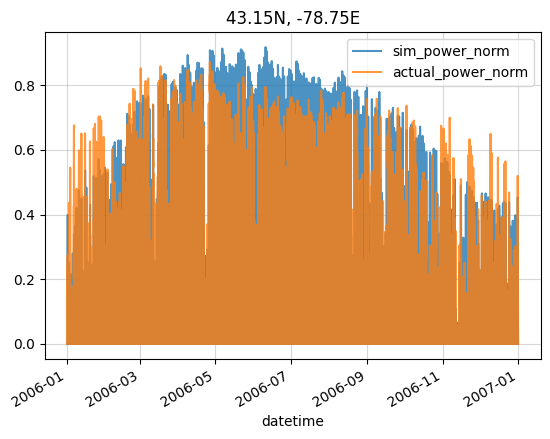

In [4]:
# Example plot
lat, lon = latlons[0]
fig, ax = plt.subplots()
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='sim_power_norm', ax=ax, alpha=0.8)
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8)

ax.set_title(f"{lat}N, {lon}E")
ax.grid(alpha=0.5)

plt.show()

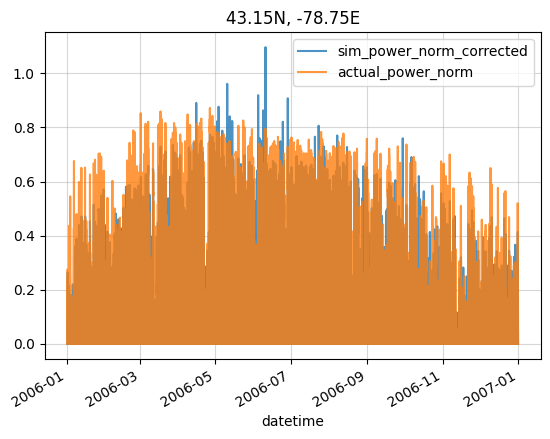

In [5]:
# Example plot
lat, lon = latlons[0]
fig, ax = plt.subplots()
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='sim_power_norm_corrected', ax=ax, alpha=0.8)
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8)

ax.set_title(f"{lat}N, {lon}E")
ax.grid(alpha=0.5)

plt.show()

In [34]:
def plot_solar_correction_fit(df, x_col, y_col, x_name=None, y_name=None):
    """
    Plot the solar correction fit.
    """
    # For nicer plotting
    months = [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]

    # Plot
    fig, axs = plt.subplots(4, 3, figsize=(10, 10))
    axs = axs.flatten()

    # Loop through months
    for idm in range(12):
        month = idm + 1
        df_month = df[df["month"] == month]
        df_month.plot(
            y=y_col,
            x=x_col,
            kind="scatter",
            s=3,
            ax=axs[idm],
            alpha=0.5,
        )
        # Add fit info
        r2 = np.corrcoef(df_month.dropna()[x_col], df_month.dropna()[y_col])[0, 1] ** 2
        rmse = np.sqrt(
            np.mean((df_month.dropna()[x_col] - df_month.dropna()[y_col]) ** 2)
        )
        # Add 1:1 line
        axs[idm].plot(
            [0, 1], [0, 1], transform=axs[idm].transAxes, ls="--", color="black"
        )
        # Tidy
        axs[idm].set_title(f"{months[idm]} (R$^2$: {r2:.2f}, RMSE: {rmse:.2f})")
        axs[idm].grid(alpha=0.5)
        axs[idm].set_xlabel("")
        axs[idm].set_ylabel("")

    fig.supxlabel(x_name if x_name is not None else x_col)
    fig.supylabel(y_name if y_name is not None else y_col)

    plt.tight_layout()
    plt.show()

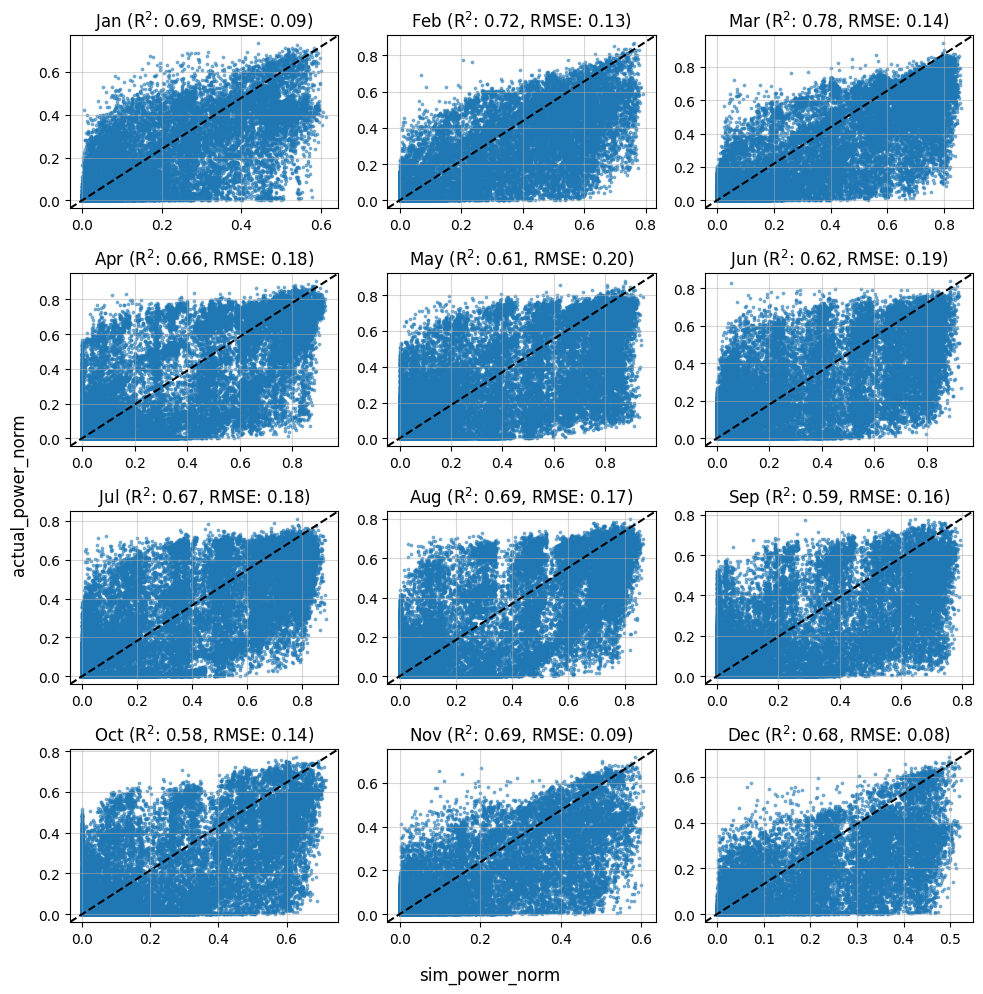

In [36]:
# Scatter
plot_solar_correction_fit(df, x_col = 'sim_power_norm', y_col = 'actual_power_norm')

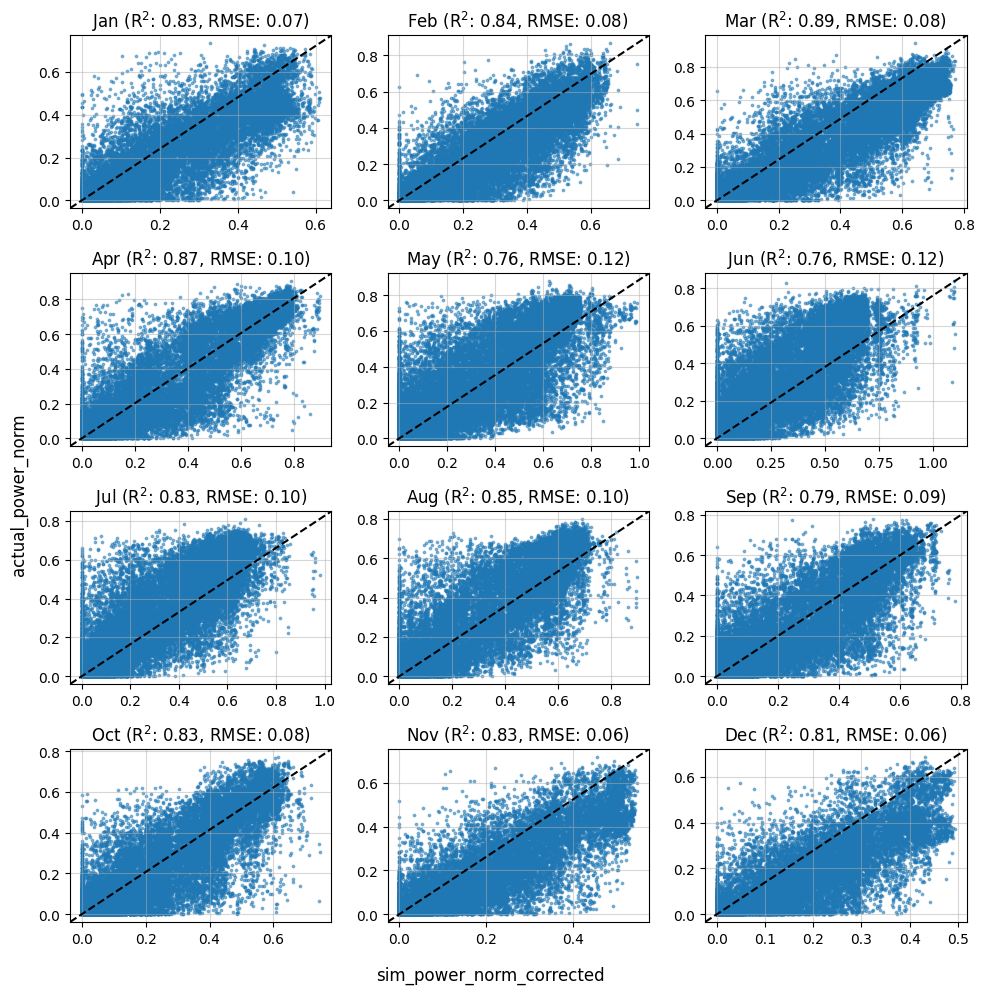

In [37]:
# Scatter
plot_solar_correction_fit(df, x_col = 'sim_power_norm_corrected', y_col = 'actual_power_norm')